NOMBRE: Alan

APELLIDOS: García Justel

# Discretización temporal no uniforme: RK4-Adaptativo

<ul id="top">
<li><a href="#Definiciones">Definiciones</a></li>
<li><a href="#1-Problemas:-órbitas-de-gran-excentricidad">1-Problemas: órbitas de gran excentricidad</a></li> 
<ul>
       <li><a href="#Problema-test:-dos-cuerpos-en-el-plano-(pertubado)">Problema-test: dos cuerpos en el plano (pertubado)</a></li> 
       <li><a href="#Problema-del-satélite-artificial">Problema del satélite artificial</a></li>
</ul>
<li><a href="#2-Métodos-RK4-y-RK4-Adaptativo">2-Métodos RK4 y RK4-Adaptativo</a></li>
      <ul>
        <li><a href="#Implementación-del-método-RK4">Implementación del método RK4</a></li>
        <li><a href="#Implementación-del-método-RK4-Adaptativo">Implementación del método RK4-Adaptativo</a></li>
</ul>  

    
<li><a href="#3-Comparativa-de-eficiencia-(error-en-energía)">3-Comparativa de eficiencia (error en energía)</a></li>


<li><a href="#4-Comparativa-de-eficiencia-(error-en-posiciones)">4-Comparativa de eficiencia (error en posiciones)</a></li>
    

</ul>  

## Definiciones

In [1]:
using LinearAlgebra
using Plots

En el tipo compuesto SolucionProblemaEDOs, hemos añadido dos campos nuevos:

- **naccept**: para contabilizar el número de pasos de integración
- **nreject**: para contabilizar el número de pasos rechazados en los métodos adaptativos

In [2]:
struct ProblemaEDOs{ftype,fltype}
    f::ftype
    u0::Vector{fltype}
    tspan::Tuple{fltype,fltype}
    p::Vector{fltype}
end

struct SolucionProblemaEDOs{ftype,fltype}
    t::Vector{fltype}
    u::Vector{Vector{fltype}}
    prob::ProblemaEDOs{ftype,fltype}
    naccept::Int64
    nreject::Int64
end

# 1-Problemas: órbitas de gran excentricidad

## Problema-test: problema perturbado de dos cuerpos en el plano

El problema de dos cuerpos en el plano describe muy bien los principales aspectos del movimiento de los satélites.
Para calcular el movimiento de dos cuerpos que se atraen mutuamente de acuerdo a la ley de gravitación universal de Newton, elegimos uno de los cuerpos como el centro de nuestro sistema de coordenadas; el movimiento del segundo cuerpo se realiza en el plano y su posición viene dada por las coordenadas $q=(q_1,q_2)$. Consideramos el problema de dos cuerpos perturbado formulado con la siguiente ecuación diferencial: 


\begin{align*}
& \frac{d}{dt} q_x= v_x, \quad  \frac{d}{dt} q_y= v_y \\
&\frac{d}{dt} v_x= - \frac{q_x}{r^3}-\epsilon \ v_x, \quad \frac{d}{dt} v_y= - \frac{q_y}{r^3} -\epsilon \ v_y\\
& \text{donde} \quad r=\sqrt{q_x^2+q_y^2}, \quad \epsilon=0.00001
\end{align*}

Los valores iniciales para $t = 0$ que describen una órbita con semieje mayor $a = 1$ y excentricidad $e$ que comienza en el pericentro están dados por

\begin{align*}
q_x(0)=1-e, \quad q_y(0)=0, \quad v_x(0)=0, \quad v_y(0)=\sqrt{(1+e)/(1-e)}
\end{align*}


Si el modelo no fuese perturbado (es decir, si $\epsilon=0$), dichas condiciones iniciales darían lugar a una órbita periódica de periodo $T=2\pi$ pero debido a la pertubación, **la órbita es solo aproximadamente periódica**. 
Consideraremos el siguiente **problema de valor inicial** para el modelo de dos cuerpos perturbado en el plano:  
 
 - Estado inicial que corresponde al valor de la excentricidad $e=0.76$
 - Intervalo de integración $(t_0,t_f)=(0.,10\pi)$

### 1.1-Ejercicio

Implementar la función que define la EDO del problema de dos cuerpos perturbado en el plano y el problema de valor inicial.

In [3]:
function f_2bodyp!(du,t,u,p)

  epsilon = p[1]
    
  qx = u[1]
  qy = u[2]
  vx = u[3]
  vy = u[4]  

  r2 = qx^2 + qy^2
  r  = sqrt(r2)
  aux = 1/(r2*r)
  
  du[1] = vx
  du[2] = vy
  du[3] = - qx * aux - epsilon * vx
  du[4] = - qy * aux - epsilon * vy 
    
  return nothing
    
end

epsilon = 0.00001 # Perturbación
e = 0.76 # Excentricidad
t0 = 0.0
tf = 10 * pi

p = [epsilon]
tspan=(t0,tf)
u0_2body=[1 - e, 0.0, 0.0, sqrt( (1 + e)/(1 - e) ) ]

prob_test=ProblemaEDOs(f_2bodyp!, u0_2body, tspan, p);

Para comprobar que la implementación es correcta, evaluar la función f_2bodyp!() tomando como argumentos el estado inicial.

In [4]:
du = similar(u0_2body)
f_2bodyp!(du, t0, u0_2body, p)
@show(du);

du = [0.0, 2.7080128015453204, -17.36111111111111, -2.7080128015453206e-5]


> **Resultado esperado**
>
>    du = [0.0, 2.7080128015453204, -17.36111111111111, -2.7080128015453206e-5]

## Problema del satélite artificial

Consideraremos la evolución de un satélite artificial moviéndose bajo el influjo gravitacional de la tierra. 

 En el modelo matemático que consideramos a continuación, se tiene en cuenta el ligero achatamiento que presenta la tierra en los polos. (Sin embargo, no se tiene en cuenta otros efectos de índole menor, como  el efecto gravitacional de la luna, el sol, y otros cuerpos celestes, ni el efecto de irregularidades menores del campo gravitacional de la tierra).
Las unidades utilizadas son kilómetros para la distancia, y segundos para el tiempo.

Según este modelo matemático, las coordenadas respecto del centro de la tierra $(x,y,z)$ del satélite obedecen el siguiente sistema de ecuaciones diferenciales:

\begin{align*}
\frac{d}{dt} 
\left(
  \begin{matrix}
    x \\ y \\ z \\v_x \\ v_y\\ v_z
  \end{matrix}
\right)
&=
\left(
  \begin{matrix}
 v_x\\
 v_y\\
 v_z\\
 \displaystyle -\mu \frac{x}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
 \displaystyle -\mu \frac{y}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, F \right)\\ 
\displaystyle-\mu \frac{z}{r^3} \left(1 + \frac{\epsilon R^2}{r^2}\, G \right)
  \end{matrix}
\right).
    \end{align*}

donde 
\begin{align*}
r=\sqrt{x^2+y^2+z^2}, \quad
  F = \frac{3}{2} -  \frac{15z^2}{2r^2},  \quad G = \frac{9}{2} - \frac{15z^2}{2r^2},
\end{align*}

y $\mu$, $R$, y $\epsilon$, respectivamente, son la constante gravitacional, el radio, y el coeficiente de achatamiento del planeta alrededor del cual se mueve el satélite artificial. En el caso de la tierra, tenemos que

\begin{equation*} 
    \mu = 398600.8 Km^3/s^2, \quad R = 6\, 378.135Km,  \quad               
    \epsilon = 0.0010826157.
\end{equation*}

    
Este es un sistema conservativo, en el que la energía del sistema se mantiene constante a lo largo de cada solución. Dicha energía es

\begin{equation*}
E(u,\mu) = \frac12\, (v_x^2 + v_y^2+ v_z^2) - \frac{\mu}{r}
-\frac{\mu  R^2 \epsilon }{2\, 
   r^3}+\frac{3 \mu  R^2 z^2 \epsilon }{2\, r^5},
\end{equation*}

donde $u$ es el vector de estados $u=(x,y,z,v_x,v_y,v_z)$. (En realidad $E(u,\mu)$ es la energía del satélite divida por su masa, pero nos referiremos a $E(u,\mu)$ como la energía del sistema.)

Aparte de la energía, también se conserva la componente vertical del momento angular, es decir,  $x v_y - y v_x.$

#### Condiciones iniciales

A lo largo del presente documento, consideraremos las siguientes condiciones iniciales:

\begin{equation*}
  \begin{split}
 x(0)&=1.1959886901183693e4 \, Km,\  \qquad y(0)=-1.6289448826603336e4 \, Km,\  \qquad z(0)=-5.963757695165331e3\, Km, \\ 
 v_x(0)&=4.724300951633136 \, Km/s, \quad v_y(0)=-1.1099935305609756 \, Km/s, \quad v_z(0)=-0.3847854410416176\,  Km/s
  \end{split}
\end{equation*}

corresponden a **un satélite de gran excentricidad** ($e=0.7679436$), es decir, que permanece gran parte de su tiempo en las proximidades del apogeo y pasa muy rápido por el resto de regiones. 

In [5]:
q0 = [1.1959886901183693e4,-1.6289448826603336e4,-5.963757695165331e3] # Km   
v0 = [4.724300951633136,-1.1099935305609756,-0.3847854410416176]        #km/s  
u0_sat = vcat(q0,v0); 

#### Orbita aproximadamente periódica

Si la tierra fuera una esfera con campo gravitacional uniforme, dichas condiciones iniciales darían lugar a una  órbita periódica de periodo $T=47120.401733054\, s$ .  Pero dado que en el modelo matemático considerado se tiene en cuenta el ligero achatamiento de la tierra en los polos, **la órbita del satélite es solo aproximadamente periódica**.

### 1.2-Ejercicio

Implementar la función que define la EDO del satélite, la función del cálculo de la energía del sistema y el problema de valor inicial para el intervalo de integración $(t_0, t_f)=(0, 40T)$.

In [6]:
function fsat!(du,t,u,p)
    
    mu = p[1]
    R = p[2]
    epsi = p[3]
    x = u[1]
    y = u[2]
    z = u[3]
    du[1] = u[4]
    du[2] = u[5]
    du[3] = u[6]
    r2 = x^2+y^2+z^2
    r = sqrt(r2)
    aux1 = -mu/(r*r2)
    F = 1.5 - 7.5*(z/r)^2
    G =  3 + F
    aux2 = epsi*(R/r)^2
    aux3 = aux1*(1+aux2*F)
    aux4 = aux1*(1+aux2*G)
    du[4]=aux3*x
    du[5]=aux3*y
    du[6]=aux4*z
    return nothing
end

"""
Energia
"""
function Efun(u,p) 

    mu  = p[1] # mu
    R   = p[2] # 
    epsi = p[3] # epsilon
    
    x   = u[1]
    y   = u[2]
    z   = u[3]
    vx  = u[4]
    vy  = u[5]
    vz  = u[6]

    z2 = z^2
    R2 = R^2
    r2 = x^2 + y^2 + z2
    r = sqrt(r2)
    r3 = r2 * r
    r5 = r2 * r2 * r 
    
    energia = (1/2) * (vx^2 + vy^2 + vz^2) - (mu/r) - ((mu*R2*epsi)/(2*r3)) + ( (3*mu*R2*z2*epsi)/(2*r5) )  
    return energia
end

"""
Problema de valor inicial
"""

T   = 47120.401733054
t0  = 0.
tf  = 40*T
tspan = (t0,tf)

mu   = 398600.8
R    = 6378.135
epsi = 0.0010826157

p_sat = [mu, R, epsi]
prob_sat=ProblemaEDOs(fsat! ,u0_sat, tspan, p_sat);

#### Comprobación

Para comprobar que la implementación es correcta, evaluar la función fsat!() tomando como argumentos el estado inicial.

In [7]:
du = similar(u0_sat)
fsat!(du, t0, u0_sat, p_sat)
@show(du);

du = [4.724300951633136, -1.1099935305609756, -0.3847854410416176, -0.0005096837257483133, 0.0006941927659456352, 0.00025422772057306594]


> **Resultado esperado**
>
>    du = [4.724300951633136, -1.1099935305609756, -0.3847854410416176, -0.0005096837257483133, 0.0006941927659456352, 0.00025422772057306594]

<a href="#top">Volver al inicio</a>

## 2-Métodos RK4 y RK4-adaptativo



### Definición de los métodos

En este ejercicio, haremos uso del método de Runge-Kutta clásico de orden 4. Utilizaremos dos versiones de dicho método: 

1. **El método implementado para una discretización temporal uniforme**, que implementaremos como una función llamada **RK4**, con los mismos argumentos de entrada y salida del método **EulerMejorado** implementado en un ejercicio anterior.



2. **El método implementado con discretización temporal no uniforme**. 
Debéis aplicar el esquema adaptativo propuesto en el documento del **2ª parte del Tema-2** disponible en el aula virtual.





### 2.1- Implementación del método RK4 de paso constante


Fijada una longitud de paso $h$, se calcula para $j=0,1,2,\dots$

\begin{align*}
&t_{j+1}=t_j+h, \qquad 
u_{j+1}=u_j+\frac{h}{6} \left(F_1+2F_2+ 2 F_3+ 4 F_4
                                           \right) \\ \\
& \text{donde} \\
& F_1=f(t_j,u_j) \\
& F_2=f\left(t_j+\frac{h}{2} , \ u_j+\frac{h}{2} F_1\right) \\
& F_3=f\left(t_j+\frac{h}{2},  \ u_j+\frac{h}{2} F_2\right) \\
& F_4= f\left(t_j+h , \ u_j+h  F_3\right)
\end{align*}



#### 2.1.1-Ejercicio



In [8]:
function  RK4(problema::ProblemaEDOs{ftype,fltype};dt::fltype,save_everystep=true) where {ftype<:Function, fltype<:AbstractFloat}
    
    u0=problema.u0
    t0,T=problema.tspan
    p=problema.p
    f=problema.f
    
    #
    uj_ = similar( u0 )
    F1  = similar(u0)
    F2  = similar(u0)
    F3  = similar(u0)
    F4  = similar(u0)
    #
    if (T-t0)>0 
     signdt=1            # integración hacia adelante
    else
     signdt=-1           # integración hacia atrás
    end
  
    h = min(dt, abs(T-t0))

    tt = [t0]
    uu = [copy(u0)]
    tj = t0
    uj=copy(u0)

    final = false
    naccept=0
    nreject=0

    while !final

        sdt=signdt*h

        RK4Step!(uj,tj,sdt,f,p,uj_,F1,F2,F3,F4)
        tj += sdt
        naccept+=1

        if save_everystep
            push!(tt,tj)
            push!(uu,copy(uj))
        end

        # Condicion de parada
        if tj == T
            final = true
        else
            # Mínimo entre dt y "lo que nos queda para llegar al final"
            h = min(dt, abs( T-tj )) 
        end
        
    end

    if !save_everystep
         push!(tt,tj)
         push!(uu,copy(uj))
    end
    #
    return SolucionProblemaEDOs(tt, uu, problema, naccept, nreject)
  end



function RK4Step!(uj, tj, h, f!, p, uj_, F1, F2, F3, F4)
    f!(F1, tj, uj, p) # F1
    @. uj_ = uj + h / 2 * F1

    tj_ = tj + h / 2
    f!(F2, tj_, uj_, p) # F2

    @. uj_ = uj + h / 2 * F2

    f!(F3, tj_, uj_, p) # F3
    @. uj_ = uj + h * F3

    tj_ = tj + h
    f!(F4, tj_, uj_, p) # F4

    @. uj = uj + (h / 6) * (F1 + 2 * F2 + 2 * F3 + F4)
    # tj = tj_
end   

RK4Step! (generic function with 1 method)

<a href="#top">Volver al inicio</a>

#### Comprobaciones de la implementación RK4 

##### 2.1.2-Ejercicio

Resolver numéricamente (con el método RK4) el modelo de dos cuerpos en el plano aplicando la longitud de paso $h=t_f/5000$ y mostrar gráficamente la orbita elíptica.
 
 

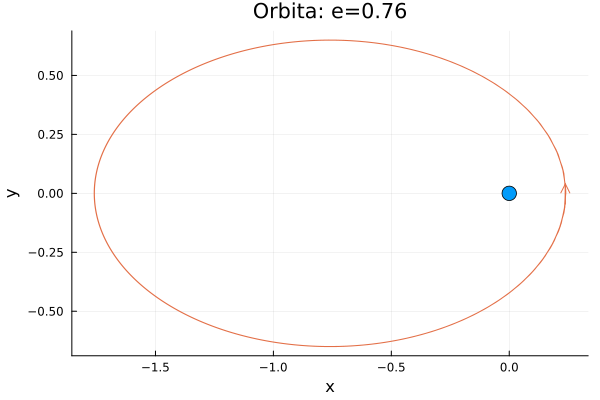

In [9]:
tf  = prob_test.tspan[2]
dt0 = tf / 5000
sol = RK4(prob_test, dt=dt0) 


tt = sol.t
xx = [ u[1] for u in sol.u ]
yy = [ u[2] for u in sol.u ]

m0 = max(1,div(Int64(ceil((tf-t0)/dt0)),1000))   # Para integraciones largas mostramos como máximo 1000 puntos de la solución
plot([0.],[0.], marker=8, title="Orbita: e=$e", label="",  aspect_ratio=1)
plot!(xx[1:m0:end],yy[1:m0:end], arrow=true, xlabel="x", ylabel="y", label="")

##### 2.1.3-Ejercicio

Para calcular el error en el tiempo $t_n=t_f$, nos apoyaremos en una segunda integración hacia atrás en el tiempo que llamaremos sol_back.

Si integramos el problema hacia atrás en el tiempo  en el intervalo $(tf, 0)$  partiendo del estado final obtenido en la integración hacia adelante (sol), el estado final de esta nueva integración coincidirá con las posiciones y velocidades iniciales originales. Por tanto, el error en el tiempo $t_n=t_f$ se puede calcular de forma exacta como:

$$
\text{error} = \| \text{sol.u}_{0} - \text{sol\_back.u}_{n} \|
$$


Determinar el error en el tiempo final $t_n=t_f$ para diferentes aproximaciones obtenidas con el método RK4: concretamente con las aproximaciones obtenidas aplicando n = [5000, 10000, 15000, 20000] pasos.

In [10]:
steps = [5000, 10000, 15000, 20000]

t0 = prob_test.tspan[1]
tf = prob_test.tspan[2]
tspan_back=(tf,t0)

for n in steps
   dt0 = tf / n

   sol = RK4(prob_test, dt=dt0)
   prob_test_back=ProblemaEDOs(f_2bodyp!, sol.u[end], tspan_back, p)
   sol_back=RK4(prob_test_back,dt=dt0)
   error = norm( sol.u[1] - sol_back.u[end] )
   
   println("pasos=", sol.naccept, ", error=", Float32(error))
    
end

pasos=5001, error=0.00080601167
pasos=10000, error=2.521108e-5
pasos=15001, error=3.3205508e-6
pasos=20000, error=7.880526e-7


>**Comprobación**
>
> Se espera que al diminuir la longitud de paso el error vaya disminuyendo


##### 2.1.4-Ejercicio

Estudiar de la eficiencia de la implementación, empleando la **macro @time** que nos devuelve tanto el tiempo de ejecución (en segundos) como la memoria reservada empleada por una función. Debemos comprobar que la memoria reservada por la implementación del método RK4 sea constante e independiente de los pasos de integración.

Para ello ejecutaremos dos integraciones del problema $\text{prob\_test}$ que unicamente devuelve el estado inicial $u_0$ y la aproximación del estado $u$ en el tiempo final $t=t_f$ verificando que en ambas el número de reservas de memoria es el mismo:

- Integración de $5000000$ pasos e indicando save_everystep=false. 
- Integración de $10000000$ pasos e indicando save_everystep=false.

In [11]:
tf = prob_test.tspan[2]
dt0 = tf / 5000000

sol=RK4(prob_test,dt=dt0,save_everystep=false)
println("num. pasos=",sol.naccept,", num. resultados=",length(sol.t))

@time RK4(prob_test,dt=dt0,save_everystep=false);

num. pasos=5000001, num. resultados=2
  0.250396 seconds (25 allocations: 1.203 KiB)


In [12]:
tf = prob_test.tspan[2]
dt0 = tf / 10000000

sol=RK4(prob_test,dt=dt0,save_everystep=false)
println("num. pasos=",sol.naccept,", num. resultados=",length(sol.t))

@time RK4(prob_test,dt=dt0,save_everystep=false);

num. pasos=10000001, num. resultados=2
  0.504725 seconds (25 allocations: 1.203 KiB)


>**Resultado esperado**
>
> La memoria reservada debe ser la misma en ambas ejecuciones: ($\approx15$ allocations). En cambio, el tiempo de ejecución será aproximadamente proporcional al número de pasos dados.

### 2.2-Ejercicio: implementación del método RK4 de paso adaptativo


#### 2.2.1-Ejercicio

En este apartado, implementaremos el método RK4 de paso adaptativo en Julia.

Los argumentos de entrada son los siguientes:  problema, $tol \ , dt, \ \mathrm{maxtrials}$ y $\text{save\_everystep}$.
Como argumentos de entrada adicionales tenemos:

- $\boldsymbol{tol}$: número real positivo que contiene el valor del parámetro de control de error descrito en el Algoritmo de Runge-Kutta con paso variable disponible en el Tema 2 del aula virtual.
- $\boldsymbol{dt}$: número real positivo que contiene la longitud de paso inicial.
- $\textbf{maxtrials}$: entero positivo que contiene el número máximo de longitud de pasos distintas que se intentarán en el cómputo de un paso de integración.
- $\textbf{save\_everystep}$: variable booleana; para $\text{save\_everystep}=false$ la función devolverá unicamente el valor inicial y final de la integración.

El resultado de la función RK4 para el método del paso adaptativo será, un objeto SolucionProblemaEDOs que contiene en el campo t los valores de los tiempos $t_0,t_1,t_2,\ldots$ de la discretización temporal no uniforme generada internamente por el algoritmo, en el campo u los vectores $u_j \approx u(t_j)$ ($j=0,1,2,\ldots$). 


In [13]:
function RK4(problema::ProblemaEDOs{ftype,fltype}, tol::fltype; dt::fltype, maxtrials=5, save_everystep=true) where {ftype<:Function,fltype<:AbstractFloat}
    u0 = problema.u0
    t0, T = problema.tspan
    p = problema.p
    f = problema.f

    naccept = 0
    nreject = 0

    if (T - t0) > 0
        signdt = 1 # integración hacia adelante
    else
        signdt = -1 # integración hacia atrás
    end
    #
    fact = 1 / (2^4 - 1)

    uj_ = similar(u0)
    uj1 = similar(u0)
    uj2 = similar(u0)
    diff = similar(u0)
    F1 = similar(u0)
    F2 = similar(u0)
    F3 = similar(u0)
    F4 = similar(u0)
    Eh = zero(eltype(u0)) # para poder acceder fuera del while donde está definida
    sdt = zero(eltype(u0)) # para poder acceder fuera del while donde está definida

    tt = [t0]
    uu = [copy(u0)]
    tj = t0
    uj = copy(u0)

    hj = dt
    final = false

    while !final

        accept = false
        i = 0

        while !accept && i < maxtrials

            i += 1
            sdt = signdt * hj
            sdt_ = sdt / 2
            tj_ = tj + sdt_

            uj1 .= uj
            uj2 .= uj

            RK4Step!(uj1, tj, sdt, f, p, uj_, F1, F2, F3, F4)
            RK4Step!(uj2, tj, sdt_, f, p, uj_, F1, F2, F3, F4)
            RK4Step!(uj2, tj_, sdt_, f, p, uj_, F1, F2, F3, F4)
            @. diff = 1 / 15 * (uj1 - uj2) / sdt
            Eh = norm(diff)

            @. diff=1/15*(uj1-uj2)/sdt
            Eh = norm(diff)

            if Eh > (2 * tol)
                hj =  hj * (tol / Eh )^(1/4)
                nreject += 1
            else
                hj =  hj * (tol / Eh )^(1/4)
                accept = true
                naccept+=1 
            end
        end

        if !accept && i == maxtrials
            println("Error en el paso tj=$tj es necesario aumentar maxtrials=$maxtrials")
            return SolucionProblemaEDOs(tt, uu, problema, naccept, nreject)
        end

        tj += sdt
        uj .= uj2

        if save_everystep
            push!(tt, tj)
            push!(uu, copy(uj))
        end

        if tj == T
            final = true
        else
            hj = min(hj, abs(T - tj))
        end

    end

    if !save_everystep
        push!(tt, tj)
        push!(uu, copy(uj))
    end

    return SolucionProblemaEDOs(tt, uu, problema, naccept, nreject)
end


function RK4Step!(uj, tj, h, f!, p, uj_, F1, F2, F3, F4)
    f!(F1, tj, uj, p) # F1
    @. uj_ = uj + h / 2 * F1

    tj_ = tj + h / 2
    f!(F2, tj_, uj_, p) # F2

    @. uj_ = uj + h / 2 * F2

    f!(F3, tj_, uj_, p) # F3
    @. uj_ = uj + h * F3

    tj_ = tj + h
    f!(F4, tj_, uj_, p) # F4

    @. uj = uj + (h / 6) * (F1 + 2 * F2 + 2 * F3 + F4)
    # tj = tj_
end   

RK4Step! (generic function with 1 method)

#### Comprobaciones de la implementación RK4 de paso adaptativo


##### 2.2.2-Ejercicio

Resolver numéricamente (con el método RK4 de paso adaptativo) el modelo de dos cuerpos en el plano aplicando $tol=1e-4, dt=0.1 $ y mostrar dos gráficos:
 

   1) La órbita de la evolución de satélite pero detallando la discretización empleada por el método RK4-Adaptativo.
   
   2) Mostrar un gráfico con las longitudes de paso empleadas  durante la integración.
  
Se observará que el método ha empleado una discretización más fina cerca del **perigeo** (zona de la órbita más cercana al primer cuerpo y donde la velocidad es mayor), que la empleada cerca del **apogeo** (zona de la órbita
más alejada del primer cuerpo)

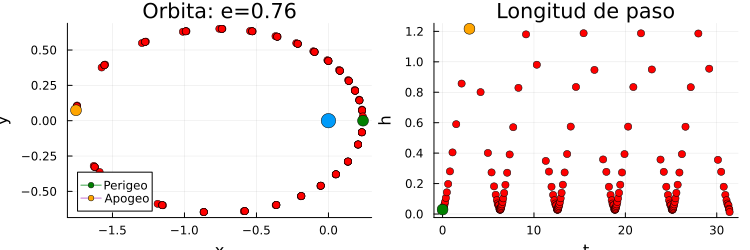

In [14]:
dt0 = 0.1
tol = 1.e-4
sol = RK4(prob_test,tol, dt=dt0) 

tt = sol.t
xx = [ u[1] for u in sol.u ]
yy = [ u[2] for u in sol.u ]

perigeo=1
apogeo=Int(argmax(map(x -> sqrt(x[1]*x[1]+x[2]*x[2]), sol.u)))


pl1=plot([0.],[0.], marker=8, title="Orbita: e=$e", label="")
pl1=plot!(xx,yy, seriestype=:scatter, mc=:red, 
          xlabel="x", ylabel="y", label="")
pl1=plot!([xx[perigeo]],[yy[perigeo]], marker=6, mc=:green,label="Perigeo")
pl1=plot!([xx[apogeo]],[yy[apogeo]], marker=6, mc=:orange,label="Apogeo")

pl2=plot(tt[1:end-1],tt[2:end]-tt[1:end-1], seriestype=:scatter, 
         title="Longitud de paso", label="", xlabel="t", ylabel="h", 
         mc=:red)

pl2=plot!([tt[perigeo]], [tt[perigeo+1]-tt[perigeo]],marker=6, mc=:green,label="")
pl2=plot!([tt[apogeo]], [tt[apogeo+1]-tt[apogeo]],marker=6, mc=:orange,label="")

plot(pl1, pl2,  layout=(1,2), size=(750,250) )

##### 2.2.3-Ejercicio

Para calcular el error en el tiempo $t_n=t_f$, nos apoyaremos en una segunda integración hacia atrás en el tiempo que llamaremos sol_back.

Si integramos el problema hacia atrás en el tiempo  en el intervalo $(t_f, 0)$  partiendo del estado final obtenido en la integración hacia adelante (sol), el estado final de esta nueva integración coincidirá con las posiciones y velocidades iniciales originales. Por tanto, el error en el tiempo $t_n=t_f$ se puede calcular de forma exacta como:

\begin{align*}
\text{error}=\|sol.u_{0}-\text{sol\_back}.u_{n}\|
\end{align*}

Determinar el error en el tiempo final $t_n=t_f$ para diferentes aproximaciones obtenidas con el método RK4-Adaptativo: concretamente con las aproximaciones obtenidas aplicando las tolerancias tols =[1.e-6, 1.e-8, 1.e-10, 1.e-12].


In [15]:
tols= [1.e-6, 1.e-8, 1.e-10, 1.e-12]
dt0=0.1
tspan_back=(tf,t0)

for tol in tols
    
   sol=RK4(prob_test,tol,dt=dt0)
   prob_test_back=ProblemaEDOs(f_2bodyp!, u0_2body, tspan_back, p)
   sol_back=RK4(prob_test_back,tol,dt=dt0)
   error=norm( sol.u[1] - sol_back.u[end] )
   println("tol=",tol,", pasos=", sol.naccept, ", pasos rechazados=", sol.nreject, ", error=", Float32(error))
    
end

tol=1.0e-6, pasos=369, pasos rechazados=54, error=0.260956
1.0e-8, pasos=1134, pasos rechazados=8, error=0.25873792
tol=1.0e-10, pasos=3585, pasos rechazados=1, error=0.2587294
tol=1.0e-12, pasos=11339, pasos rechazados=1, error=0.25872952


>**Comprobación**
> 
> Concretamente se espera obtener los siguientes resultados:

>- tol=1.0e-6, pasos=369, pasos rechazados=62, error=0.012081226
>- tol=1.0e-8, pasos=1133, pasos rechazados=10, error=8.6089975e-5
>- tol=1.0e-10, pasos=3585, pasos rechazados=3, error=3.077569e-7
>- tol=1.0e-10, pasos=11337, pasos rechazados=3, error=9.615401e-10

##### 2.2.4-Ejercicio

Estudiar de la eficiencia de la implementación, empleando la **macro @time** que nos devuelve tanto el tiempo de ejecución (en segundos) como la memoria reservada empleada por una función. Debemos comprobar que la memoria reservada por la implementación del método RK4-Adaptativo sea constante e independiente de los pasos de integración.

Para ello ejecutaremos dos integraciones del problema $\text{prob\_test}$ que unicamente devuelve el estado inicial $u_0$ y la aproximación del estado $u$ en el tiempo final $t=t_f$ verificando que en ambas el número de reservas de memoria es el mismo:

- Integración aplicando $tol=1.e-10$ y save_everystep=false
- Integración aplicando $tol=1.e-12$ y save_everystep=false

In [16]:
tol=1.e-10
sol=RK4(prob_test,tol,dt=dt0)
sol_comp=RK4(prob_test,tol,dt=dt0,save_everystep=false)    # compilación
@time RK4(prob_test,tol,dt=dt0,save_everystep=false)
println("pasos=", length(sol.t)-1, ", naccept=", sol.naccept)

  0.000979 seconds (31 allocations: 1.484 KiB)
3585, naccept=3585


In [17]:
tol=1.e-12
sol=RK4(prob_test,tol,dt=dt0)
sol_comp=RK4(prob_test,tol,dt=dt0,save_everystep=false)    # compilación
@time RK4(prob_test,tol,dt=dt0,save_everystep=false)
println("pasos=", length(sol.t)-1, ", naccept=", sol.naccept)

  0.002574 seconds (31 allocations: 1.484 KiB)
pasos=11339, naccept=11339


>**Resultado esperado**
>
> La memoria reservada debe ser la misma en ambas ejecuciones: ($\approx 18$ allocations). En cambio, el tiempo de ejecución será aproximadamente proporcional al número de pasos dados.

<a href="#top">Volver al inicio</a>

# 3-Comparativa de eficiencia (error en energía)



Utilizaréis ambos versiones del método RK de orden 4 para simular la evolución de las coordenadas $(x(t),y(t),z(t))$ de posición (y la velocidad $(v_x(t),v_y(t),v_z(t))$) del problema del satélite llamado **prob_sat** cuya órbita es aproximadamente periódica. Midiendo el error en la energía y tiempo de ejecución, se trata de determinar cual de los dos métodos resulta más eficiente para la simulación de satélites de gran excentricidad.

### 3.1-Evolución de la energía para el método RK4


#### 3.1.1-Ejercicio

Aplicar el método RK4 al problema prob_sat, para calcular aproximaciones de la solución $u(t)=(x(t),y(t),z(t),v_x(t),v_y(t), v_z(t))$ aplicando el tamaño de paso $dt=\dfrac{tf}{200000}$.

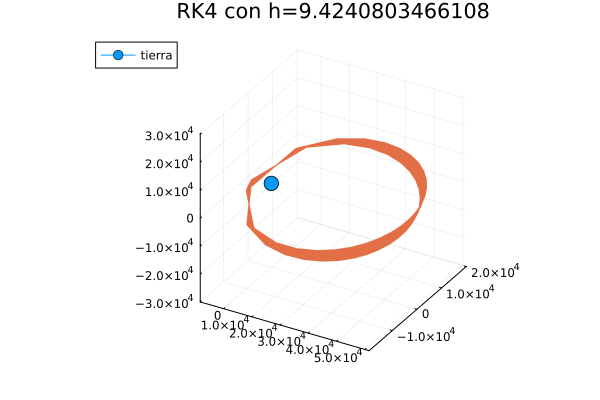

In [18]:
t0=0.0
tf=40*T
dt0=tf/200000



sol = RK4(prob_sat,dt=dt0)
pasos_RK4=sol.naccept

tt = sol.t
xx = [ u[1] for u in sol.u ]
yy = [ u[2] for u in sol.u ]
zz = [ u[3] for u in sol.u ]

m0 = max(1,div(Int64(ceil((tf-t0)/dt0)),1000))

plot([0.],[0.],[0.],marker=8,label="tierra",
      title= "RK4 con h=$(dt0)")
      
plot!(xx[1:m0:end],
      yy[1:m0:end],
      zz[1:m0:end], aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="")
     

#### 3.1.2-Ejercicio

Calcular los valores de la energía del sistema y representar dichos valores de la energía con respecto al tiempo.

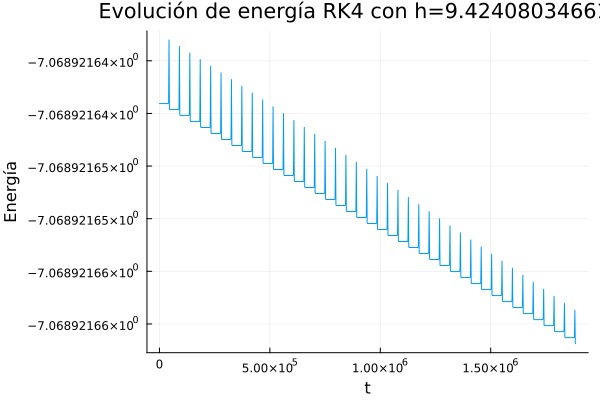

In [19]:
EE = [Efun(u, p_sat) for u in sol.u]

pl1=plot(sol.t[1:m0:end],EE[1:m0:end],
         xlabel="t",ylabel="Energía",label="", 
         title="Evolución de energía RK4 con h=$dt0")
         

#### 3.1.3-Ejercicio

Calculo de errores relativos en energía.

Observese que la energía no se mantiene constante, sino que varía a lo largo del tiempo. Si para cada $k=1,2,\ldots,n$, la aproximación $u_k$ fuese igual a la solución exacta
$$u(t_k)=(x(t_k), y(t_k), z(t_k), v_x(t_k), v_y(t_k),v_z(t_k)),$$ 

entonces $E(u_k,p)$ sería exactamente igual a $E(u_0,p)$. Dichas variaciones del valor de la energía permiten medir de una forma sencilla el nivel de precisión de la aplicación del método RK4. Para ello, calcularemos los _errores relativos en energía_: para cada $k$, el error relativo en energía en $t=t_k$ es 
$$\left|\frac{E(u_k,p)}{E(u_0,p)}-1 \right|.$$ 
En lo que sigue, omitiremos el calificativo relativo y nos referiremos a él simplemente como _error en energía_.

In [20]:
err = ??
errE_RK4=??   # error relativo en energía al final de la integración

plot(sol.t[1:m0:end],err[1:m0:end],  
     xlabel="t",ylabel=ylabel="ΔE",label="", 
     title="Evolución de errores en energía RK4 con h=$dt0")

LoadError: ParseError:
[90m# Error @ [0;0m]8;;file:///workspaces/KISA/src/CCI/In[20]#1:7\[90mIn[20]:1:7[0;0m]8;;\
err = [48;2;120;70;70m?[0;0m?
[90m#     ╙ ── [0;0m[91mnot a unary operator[0;0m

#### 3.1.4-Ejercicio

Cálculo del tiempo de ejecución.

En este caso, para medir la eficiencia de cada método emplearemos el macro **@elapsed** que devuelve el tiempo de computación (en segundos) de la ejecución de una función.
Para medir el tiempo de ejecución de una simulación de la manera más objetiva posible, consideraremos la media de los tiempos de CPU (elapsed time) en un número determinado de ejecuciones que fijaremos en el **parámetro nruns** y aplicaremos **save_everystep=false**.

In [ ]:
nruns=10

sol_comp=RK4(prob_sat,dt=dt0,save_everystep=false)         # compilación
cpu_RK4=0.
for i in 1:nruns
    cpu_RK4+=@elapsed RK4(prob_sat,dt=dt0,save_everystep=false) 
end
cpu_RK4=??

println("Longitud paso=",Float32(dt0),",Numero de pasos: ",pasos_RK4, ", Tiempo CPU=", cpu_RK4, " s",", error en energia al final=", Float32(errE_RK4))

### 3.2-Evolución de la energía para el método RK4-Adaptativo

Repetir los cálculos del apartado anterior, pero aplicando el método RK4-Adaptativo 

#### 3.2.1-Ejercicio

Aplicar el método RK4-Adaptativo con tolerancia $\mathrm{tol}=10^{-11}$ y $h_0=0.1$ y mostrar la trayectoria del satélite:

In [ ]:
tol = ??
dt0 = ??

sol = RK4(prob_sat,tol,dt=dt0)    
pasos_RK4a=??

tt = ??
xx = ??
yy = ??
zz = ??

plot([0.],[0.],[0.],marker=8,label="Tierra")
plot!(xx,yy,zz, aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="")

#### 3.2.2-Ejercicio

Cálculo de errores relativos en energía

In [ ]:
EE=[?? for u in sol.u]

err = ??
errE_RK4a=?? # error relativo en energía al final de la integración
println("error en energia al final=", Float32(errE_RK4a))

plot(sol.t,err, 
     xlabel="t",ylabel=ylabel="ΔE",label="", 
     title="Evolución errores energía RK4a tol=$tol")

#### 3.2.3-Ejercicio

Cálculo del tiempo de ejecución

In [ ]:
sol_comp=RK4(prob_sat,tol,dt=dt0,save_everystep=false)    # compilación
cpu_RK4a=0.
for i in 1:nruns
    cpu_RK4a+=@elapsed RK4(prob_sat,tol,dt=dt0,save_everystep=false)
end
cpu_RK4a=??

#### 3.2.4-Ejercicio

Conclusiones sobre la comparativa de eficiencia entre RK4 y RK4-Adaptativo

In [ ]:
println("Numero de pasos: ",pasos_RK4, ", Tiempo CPU=", cpu_RK4, " s",", error en energia al final=", Float32(errE_RK4))

In [ ]:
println("Numero de pasos: ",pasos_RK4a, ", Rechazados: ", ??, ", Tiempo CPU=", cpu_RK4a, " s",", error en energia al final=", Float32(errE_RK4a))

> **¿Cuál de los dos métodos ha resultado más eficiente?**
>
> 

<a href="#top">Volver al inicio</a>

# 4-Comparativa de eficiencia (error en posiciones)


Utilizaréis ambas versiones del método RK de  orden 4 para simular la evolución de las coordenadas $(x(t),y(t),z(t))$ de posición (y la velocidad $(v_x(t),v_y(t),v_z(t))$) del problema del satélite llamado **prob_sat** cuya órbita es aproximadamente periódica. Midiendo el error en posiciones y  tiempo de ejecución, se trata de determinar cual de los dos métodos resulta más eficiente para la simulación de satélites de gran excentricidad.


 


### 4.1-Método RK4


#### 4.1.1-Ejercicio

Aplicar el método RK4 al problema prob_sat, para calcular aproximaciones de la solución $u(t)=(x(t),y(t),z(t),v_x(t),v_y(t), v_z(t))$ aplicando el paso constante $dt=\dfrac{tf}{200000}$.

In [ ]:
tf=??
dt0=??

sol = RK4(prob_sat,dt=dt0)
pasos_RK4=??

tt = ??
xx = ??
yy = ??
zz = ??

m0 = max(1,div(Int64(ceil((tf-t0)/dt0)),1000))

plot([0.],[0.],[0.],marker=8,label="tierra",
      title= "RK4 con h=$(dt0)")
      
plot!(xx[1:m0:end],
      yy[1:m0:end],
      zz[1:m0:end], aspect_ratio=1., zlimit=(-3.0e4,3.04e4),  label="")

#### 4.1.2-Ejercicio

Para calcular el error en el tiempo $t_n=t_f$, nos apoyaremos en una segunda integración hacia atrás en el tiempo que llamaremos sol_back. Concretamente el error en posiciones lo calcularemos de la siguiente manera,

$$error=\|sol.(x_0,y_0,z_0)-\text{sol\_back}.(x_n,y_n,z_n)\|$$

donde sol_back.u corresponde a la aproximación obtenida integrando el problema hacia atrás en el tiempo.

In [ ]:
tspan_back=(tf,t0)
prob_sat_back=ProblemaEDOs(fsat!,??,tspan_back,p_sat)
sol_back=RK4(prob_sat_back,dt=dt0)

xxback = [u[1] for u in sol_back.u]
yyback = [u[2] for u in sol_back.u]
zzback = [u[3] for u in sol_back.u]

? # varias lineas 

errpos_RK4 = ??

#### 4.1.3-Ejercicio

Calcular los tiempos de ejecución

In [ ]:
nruns=10

sol_comp=RK4(prob_sat,dt=dt0,save_everystep=false)         # compilación
cpu_RK4=0.
for i in 1:nruns
    cpu_RK4+=@elapsed RK4(prob_sat,dt=dt0,save_everystep=false) 
end
cpu_RK4=??

println("Numero de pasos: ",pasos_RK4, ", Tiempo CPU=", cpu_RK4, " s",", error en posiciones al final=", Float32(errpos_RK4))

### 4.2-Método RK4-Adaptativo


Repetir los cálculos del apartado anterior, pero aplicando el método RK4 de paso adaptativo 

#### 4.2.1-Ejercicio

Aplicar el método RK4-Adaptativo con tolerancia $\mathrm{tol}=10^{-11}$ y $h_0=0.1$

In [ ]:
tol = ??
dt0 = ??

sol = RK4(prob_sat,tol,dt=dt0)
pasos_RK4a=??

#### 4.2.2-Ejercicio

Calcular el error en el tiempo $t_n=t_f$

In [ ]:
t0=prob_sat.tspan[1]
tf=prob_sat.tspan[2]

tspan_back=(tf,t0)
prob_sat_back=ProblemaEDOs(fsat!,??,tspan_back,p_sat)
sol_back = RK4(prob_sat_back,tol,dt=dt0)

xxback = [u[1] for u in sol_back.u]
yyback = [u[2] for u in sol_back.u]
zzback = [u[3] for u in sol_back.u]

? # varias líneas

errpos_RK4a = ??

#### 4.2.3-Ejercicio

Calcular los tiempos de ejecución

In [ ]:
sol_comp=RK4(prob_sat,tol,dt=dt0,save_everystep=false)    # compilación
cpu_RK4a=0.
for i in 1:nruns
    cpu_RK4a+=@elapsed RK4(prob_sat,tol,dt=dt0,save_everystep=false)
end
cpu_RK4a=??

println("Numero de pasos: ",pasos_RK4a, ", Rechazados: ", ??, ", Tiempo CPU=", cpu_RK4a, " s",", error en posiciones al final del intervalo=", Float32(errpos_RK4a))

#### 4.2.4-Ejercicio

Conclusiones sobre la comparativa de eficiencia entre RK4 y RK4-Adaptativo

In [ ]:
println("Numero de pasos: ",pasos_RK4, ", Tiempo CPU=", cpu_RK4, " s",", error en posiciones  al final del intervalo=", Float32(errpos_RK4))

In [ ]:
println("Numero de pasos: ",pasos_RK4a, ", Rechazados: ", ??, ", Tiempo CPU=", cpu_RK4a, " s",", error en posiciones  al final del intervalo=", Float32(errpos_RK4a))

> **¿Cuál de los dos métodos ha resultado más eficiente?**
>
>> 

<a href="#top">Volver al inicio</a>